### Code for generation of anndata object
_Single cell trajectory mapping of human pluripotent stem cells differentiating towards lung and hepatocyte progenitors_,
bioArxiv Preprint. <br> 
Chaido Ori, Meshal Ansari, Ilias Angelidis, Fabian J. Theis, Herbert B. Schiller and Micha Drukker

In [1]:
## This Notebook generates anndata object used in the Notebooks associated with Ori et al., 2020
## All single-cell analysis Figure Panels are based on this object

## Following Tables are needed as input:
#  data/Suppl_Table_4_cell_metadata.xlsx
#  data/IPS_differentiation_barcodes.txt 
#  data/IPS_differentiation_genes.txt
#  data/IPS_differentiation_metadata.txt
#  data/IPS_differentiation_hvgs_genes.txt
#  data/IPS_differentiation_coords.txt

## Following Table is produced:
#  data/Suppl_Table_5_marker_table.xlsx

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
from natsort import natsorted
import IPython

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 3
sc.logging.print_version_and_date()

Running Scanpy 1.6.1.dev110+gb4234d81, on 2021-02-17 11:20.


### Read in Data Files

In [2]:
## Read in filtered Raw Count Matrix
folder = "/20200806_Drukker_IPSlungProgenitors_meshal.ansari/"

adata = sc.read(folder + "IPS_differentiation_raw_counts.mtx")
adata.obs_names = pd.read_csv(folder + "IPS_differentiation_barcodes.txt", header = None).iloc[:, 0].values
adata.var_names = pd.read_csv(folder + "IPS_differentiation_genes.txt", header = None).iloc[:, 0].values

## Meta Data
adata.obs = pd.read_csv(folder + "IPS_differentiation_metadata.txt", sep = "\t", index_col = 0).iloc[:, :10]

## Make louvain cluster categorical
c = adata.obs["louvain_cluster"].astype("U")
adata.obs["louvain_cluster"] = pd.Categorical(c, categories = natsorted(np.unique(c)))

sc._utils.sanitize_anndata(adata)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
... storing 'sample_ID' as categorical
... storing 'day' as categorical
... storing 'GFP_NKX2.1_positive' as categorical


In [3]:
adata

AnnData object with n_obs × n_vars = 10667 × 26936
    obs: 'sample_ID', 'day', 'louvain_cluster', 'GFP_NKX2.1_positive', 'dpt', 'lung_score', 'hepatocyte_score', 'percent_mito', 'total_counts', 'total_genes'

In [4]:
print(adata.obs_names[:10].values)
print(adata.var_names[:10].values)
adata.X[5:10, :10].todense()

['muc6865_CTCGATGGCGCA' 'muc6865_TTTACGGCCATT' 'muc6865_TCACTATCCGTA'
 'muc6865_AGATGACTTAGA' 'muc6865_ATGAAGGCGTAA' 'muc6865_GCCATTAAATTA'
 'muc6865_AAAATTGACATA' 'muc6865_ACCACGACTTCG' 'muc6865_GCCGGGGATGTG'
 'muc6865_TGGCAGTGTCCT']
['A1BG' 'A1BG-AS1' 'A2M' 'A2M-AS1' 'A2ML1' 'A4GALT' 'AAAS' 'AACS'
 'AADACL3' 'AADAT']


matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

### Normalization

In [5]:
## Store counts and Raw Layer as sparse matrices
from scipy import sparse

#Keep the count data in a counts layer (before normalization !)
adata.layers["counts"] = sparse.csr_matrix(adata.X.copy())

## Normalize adata and Log Transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e6)
sc.pp.log1p(adata)

# Store the full data set in 'raw' as log-normalised data
adata.raw = sc.AnnData(X = sparse.csr_matrix(adata.X))
adata.raw.var.index = adata.var_names.copy()

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### highly variable gene selection

In [6]:
## Calculate highly variable genes
# sc.pp.highly_variable_genes(adata, n_top_genes = 1000, n_bins = 20, flavor = "seurat", subset = False)
# sum(adata.var["highly_variable"])

## Set it to previous List to be consistent
hvgs = pd.read_csv(folder + "IPS_differentiation_hvgs_genes.txt", header = None).iloc[:, 0].values
adata.var["highly_variable"] = [g in hvgs for g in adata.var_names]
sum(adata.var["highly_variable"])

521

In [7]:
## Human Cell Cycle genes
cc_genes = [x.strip() for x in open(folder + "cell_cycle_genes.txt")]
s_genes = cc_genes[:43]
g2m_genes = cc_genes[43:]
cc_genes = np.intersect1d(adata.var_names, cc_genes)
sc.tl.score_genes_cell_cycle(adata, s_genes = s_genes, g2m_genes = g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    339 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    301 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [8]:
sc.pp.regress_out(adata, ["S_score", "G2M_score", "percent_mito", "n_counts"])

regressing out ['S_score', 'G2M_score', 'percent_mito', 'n_counts']
    sparse input is densified and may lead to high memory use


... storing 'phase' as categorical


    finished (0:04:30)


In [8]:
## Calculate PCs, neighborhood graph and umap with these parameters
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps = 50, use_highly_variable = True)
sc.pp.neighbors(adata, n_pcs = 10, n_neighbors = 15)

## Original Parameters
# sc.tl.louvain(adata, resolution = 2, key_added = "louvain_cluster")
# sc.tl.umap(adata)
# sc.pl.umap(adata, color = ["louvain_cluster", "day"])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


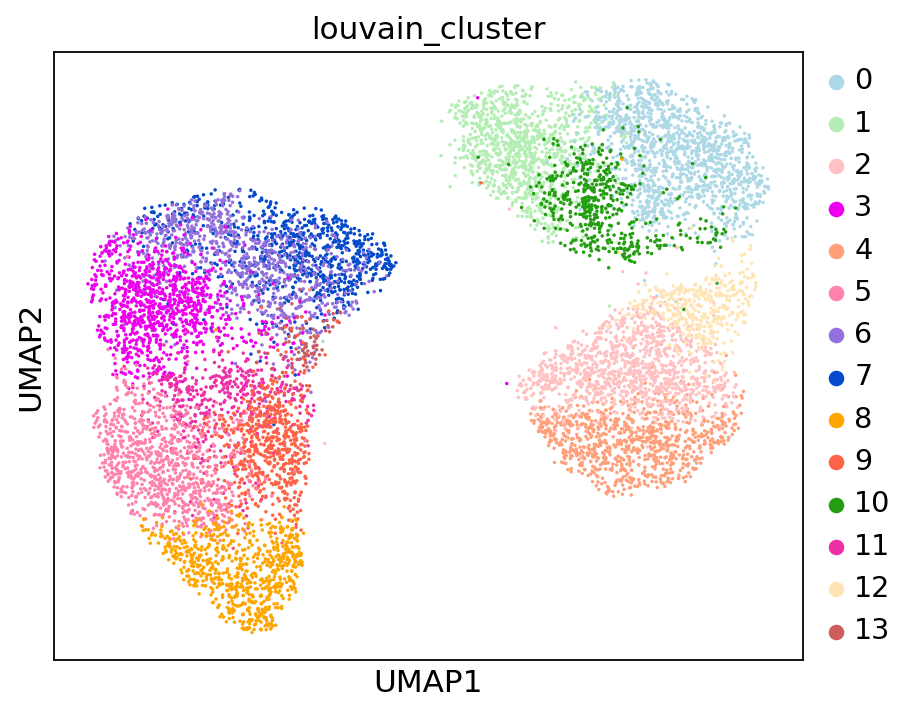

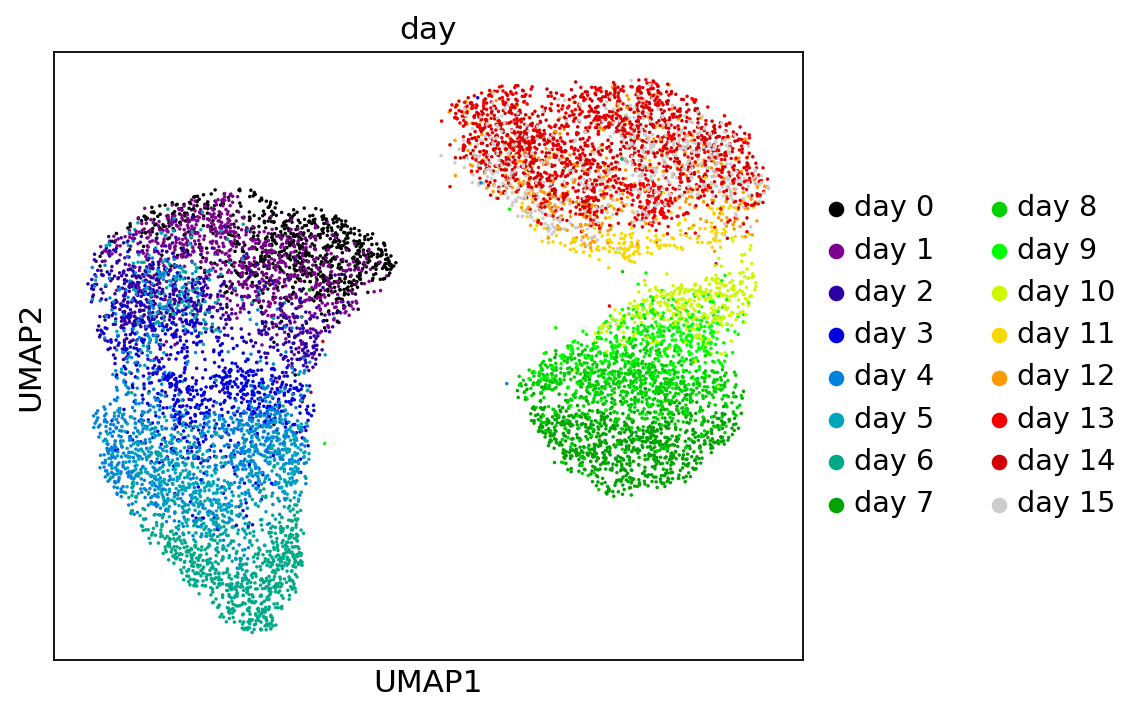

In [17]:
## Set it based on coordinates to be consistend with Paper Figures
IPython.display.set_matplotlib_formats("png2x", quality = 90)
plt.rcParams["figure.figsize"] = (6, 5)

cords = pd.read_csv(folder + "IPS_differentiation_metadata.txt", sep = "\t", index_col = 0).loc[:, ["umap_1", "umap_2"]]
adata.obsm["X_umap"] = cords.loc[adata.obs_names].values[:, :2]

## Set colours
louvain_colors = ["#ADD8E6", "#B4EEB4", "#FFC1C1", "#EE00EE", "#FFA07A", "#FF82AB", "#9370DB", "#064ACC",
                  "#FFA500", "#FF6347", "#249E11", "#EE30A7", "#FFE4B5", "#CD5C5C"]
day_colors = ['#000000', '#7d008e', '#2d00a4', '#0000dd', '#0082dd', '#00a4bb', '#00aa88', '#00a400', 
              '#00d200', '#00ff00', '#ccf900', '#f9d700', '#ff9900', '#f40000', '#d20000', '#cccccc']

sc.pl.umap(adata, color = "louvain_cluster", palette = louvain_colors, size = 10)
sc.pl.umap(adata, color = "day", palette = day_colors, size = 10)

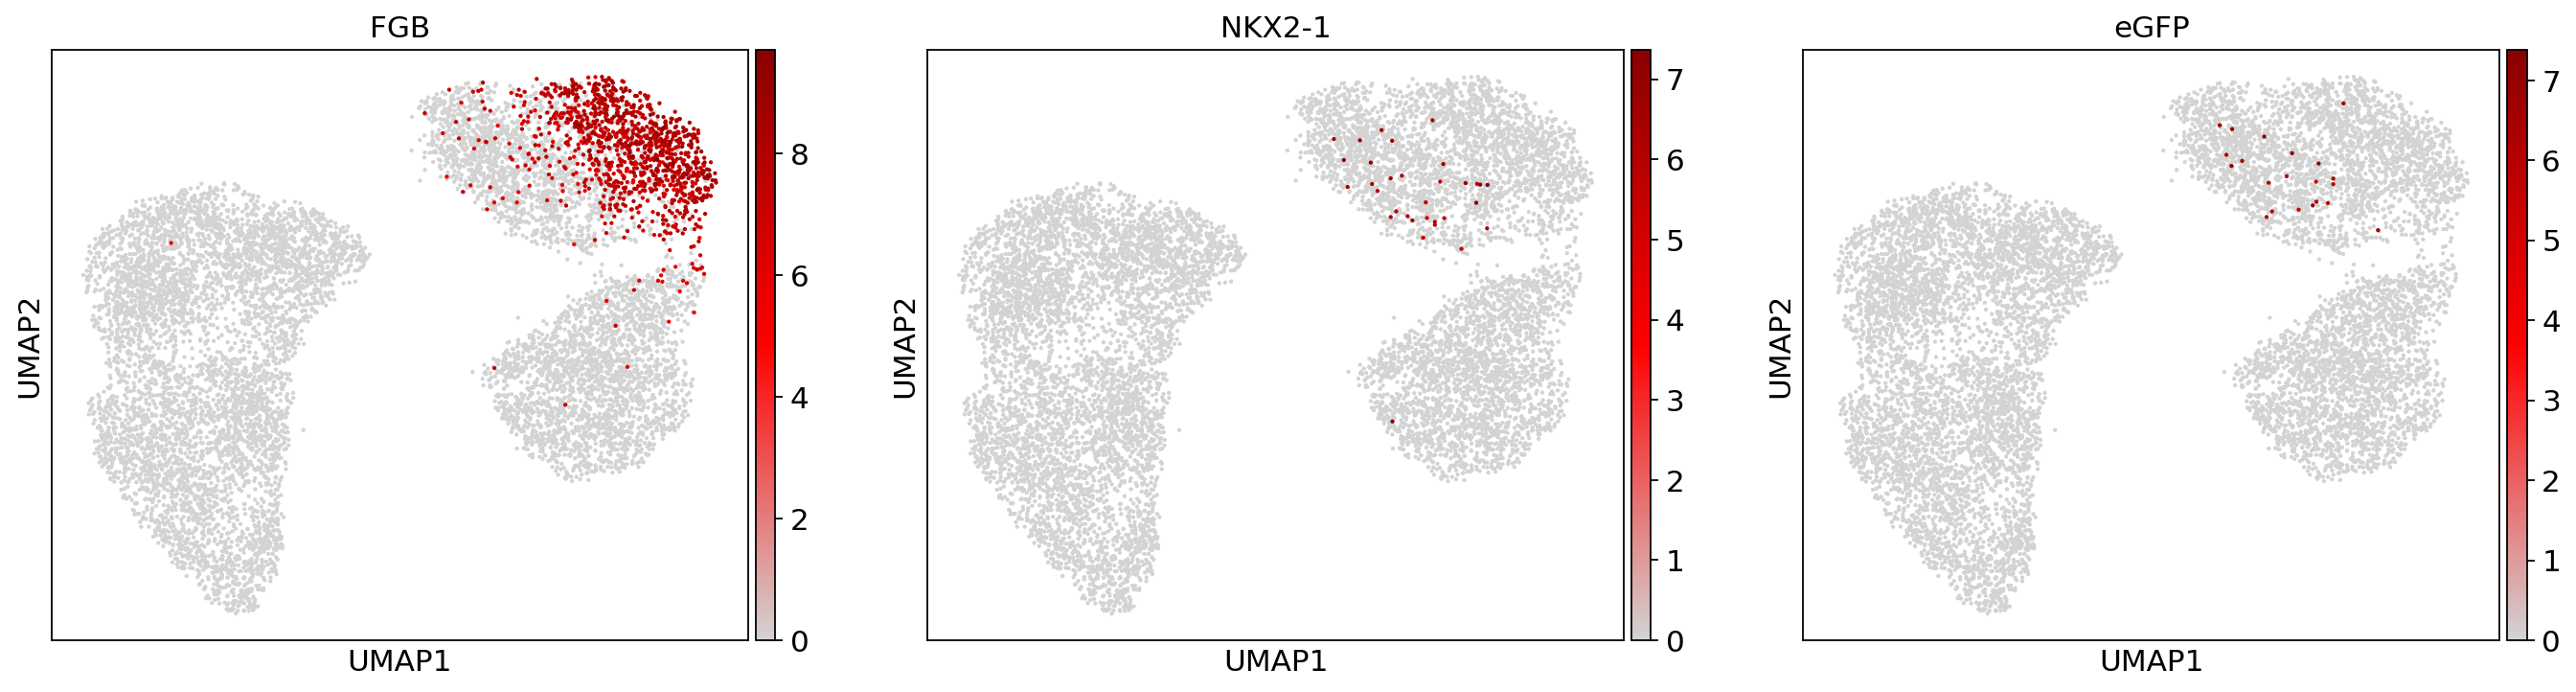

In [18]:
## Feature Plots of known lineage marker
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

sc.pl.umap(adata, color = ["FGB", "NKX2-1", "eGFP"], cmap = gray_red, size = 15)

In [ ]:
## Save the annData object
adata.write(folder + "IPS_lung_differentiation.h5ad")